<a href="https://colab.research.google.com/github/gift-framework/GIFT/blob/research/notebooks/GIFT_Correction_2M_Zeros_Trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GIFT Correction Model: $\theta(T) = \frac{10}{7} - \frac{14}{3\log T}$

**Purpose**: Validate the GIFT-derived variable-$\theta$ correction model
on Odlyzko's 2,001,052 zeros (zeros6 table, $T \leq 1{,}132{,}490$).

**Model**: The cutoff exponent is no longer constant but varies as:
$$\theta(T) = \frac{10}{7} - \frac{14}{3\,\log T}$$

| Parameter | Value | GIFT origin |
|-----------|-------|-------------|
| $\theta_\infty = 10/7$ | 1.4286 | $(\dim K_7 + N_\text{gen})/\dim K_7 = (7+3)/7$ |
| Correction coeff $= 14/3$ | 4.6667 | $\dim(G_2)/N_\text{gen} = 14/3$ |

**Runtime**: ~7h on Colab A100 (same as constant-$\theta$ notebook).
Checkpoints to Drive after every chunk — safe to resume after timeout.

**Validation**: T5 (Monte Carlo), T7 (Bootstrap CI), T8 (Drift test).

In [ ]:
import numpy as np
import os, sys, time, json, shutil, warnings
from scipy.special import loggamma, lambertw
from scipy import stats
warnings.filterwarnings('ignore')

# GPU detection
try:
    import cupy as cp
    GPU = True
    gpu_name = cp.cuda.runtime.getDeviceProperties(0)['name'].decode()
    gpu_mem = cp.cuda.runtime.getDeviceProperties(0)['totalGlobalMem'] / 1e9
    print(f"GPU: {gpu_name} ({gpu_mem:.1f} GB)")
except Exception:
    GPU = False
    print("No GPU — CPU mode (fine for core analysis)")

print(f"NumPy {np.__version__}, Python {sys.version.split()[0]}")

# Mount Google Drive
DRIVE_DIR = '/content/drive/MyDrive/GIFT_results'
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    os.makedirs(DRIVE_DIR, exist_ok=True)
    print(f"Drive mounted -> {DRIVE_DIR}")
except Exception:
    DRIVE_DIR = None
    print("No Drive — local storage only")

GPU: NVIDIA A100-SXM4-80GB (85.2 GB)
NumPy 2.0.2, Python 3.12.12
No Drive — local storage only


In [ ]:
import urllib.request

CACHE_2M = 'riemann_zeros_2M_genuine.npy'

def download_odlyzko(url, cache_file, desc):
    drive_cache = os.path.join(DRIVE_DIR, cache_file) if DRIVE_DIR else None
    if os.path.exists(cache_file):
        print(f"  Loading cached {desc} (local)...")
        return np.load(cache_file)
    if drive_cache and os.path.exists(drive_cache):
        print(f"  Loading cached {desc} (Drive)...")
        shutil.copy2(drive_cache, cache_file)
        return np.load(cache_file)
    print(f"  Downloading {desc}...")
    t0 = time.time()
    response = urllib.request.urlopen(url, timeout=300)
    raw = response.read().decode('utf-8')
    zeros = np.array([float(l.strip()) for l in raw.strip().split('\n') if l.strip()])
    print(f"    {len(zeros):,} zeros in {time.time()-t0:.1f}s")
    np.save(cache_file, zeros)
    if drive_cache:
        shutil.copy2(cache_file, drive_cache)
        print(f"    Backed up to Drive")
    return zeros

print("=" * 60)
print("DOWNLOADING RIEMANN ZEROS")
print("=" * 60)
gamma_n = download_odlyzko(
    'https://www-users.cse.umn.edu/~odlyzko/zeta_tables/zeros6',
    CACHE_2M, "2,001,052 zeros (Odlyzko zeros6)")

if gamma_n is None:
    raise RuntimeError("Download failed")

N_ZEROS = len(gamma_n)
print(f"\nLoaded {N_ZEROS:,} zeros, range [{gamma_n[0]:.3f}, {gamma_n[-1]:.3f}]")

KNOWN = [14.134725142, 21.022039639, 25.010857580, 30.424876126, 32.935061588]
for i, k in enumerate(KNOWN):
    err = abs(gamma_n[i] - k)
    print(f"  gamma_{i+1} = {gamma_n[i]:.9f}  (err: {err:.2e}) [{'OK' if err < 1e-6 else 'BAD'}]")

DOWNLOADING RIEMANN ZEROS
    2,001,052 zeros in 8.5s

Loaded 2,001,052 zeros, range [14.135, 1132490.659]
  gamma_1 = 14.134725142  (err: 0.00e+00) [OK]
  gamma_2 = 21.022039639  (err: 0.00e+00) [OK]
  gamma_3 = 25.010857580  (err: 0.00e+00) [OK]
  gamma_4 = 30.424876126  (err: 0.00e+00) [OK]
  gamma_5 = 32.935061588  (err: 0.00e+00) [OK]


In [ ]:
# ── Riemann-Siegel theta ──
def theta_rs(t):
    t = np.asarray(t, dtype=np.float64)
    return np.imag(loggamma(0.25 + 0.5j * t)) - 0.5 * t * np.log(np.pi)

def theta_deriv(t):
    return 0.5 * np.log(np.maximum(np.asarray(t, dtype=np.float64), 1.0) / (2 * np.pi))

def smooth_zeros(N):
    ns = np.arange(1, N + 1, dtype=np.float64)
    targets = (ns - 1.5) * np.pi
    w = np.real(lambertw(ns / np.e))
    t = np.maximum(2 * np.pi * ns / w, 2.0)
    for _ in range(40):
        dt = (theta_rs(t) - targets) / np.maximum(np.abs(theta_deriv(t)), 1e-15)
        t -= dt
        if np.max(np.abs(dt)) < 1e-12:
            break
    return t

def sieve(N):
    is_p = np.ones(N + 1, dtype=bool); is_p[:2] = False
    for i in range(2, int(N**0.5) + 1):
        if is_p[i]: is_p[i*i::i] = False
    return np.where(is_p)[0]

def w_cosine(x):
    return np.where(x < 1.0, np.cos(np.pi * x / 2)**2, 0.0)

# ── GIFT correction model ──
THETA_INF = 10 / 7     # (dim(K7) + N_gen) / dim(K7)
THETA_COEFF = -14 / 3  # -dim(G2) / N_gen
K_MAX = 3

def theta_gift(T):
    # theta(T) = 10/7 - (14/3)/log(T)
    logT = np.log(np.maximum(np.asarray(T, dtype=np.float64), np.e))
    return np.clip(THETA_INF + THETA_COEFF / logT, 0.5, 2.0)

def prime_sum_var(g0, tp_v, primes, k_max, theta_inf, theta_coeff, w_func):
    # Mollified prime sum with theta(T) = theta_inf + theta_coeff/log(T)
    # Set theta_coeff=0 for constant theta
    S = np.zeros_like(g0)
    log_g0 = np.log(np.maximum(g0, 2.0))
    if theta_coeff == 0.0:
        log_X = theta_inf * log_g0
    else:
        theta_per = np.clip(theta_inf + theta_coeff / log_g0, 0.5, 2.0)
        log_X = theta_per * log_g0

    for p in primes:
        logp = np.log(float(p))
        if logp / np.max(log_X) > 3.0:
            break
        for m in range(1, k_max + 1):
            x = m * logp / log_X
            weight = w_func(x)
            if np.max(weight) < 1e-15:
                continue
            S -= weight * np.sin(g0 * m * logp) / (m * p ** (m / 2.0))
    return -S / tp_v

print("Infrastructure loaded.")
print(f"  GIFT model: theta(T) = {THETA_INF:.6f} - {abs(THETA_COEFF):.6f}/log(T)")
print(f"  = 10/7 - (14/3)/log(T)")
print(f"  theta(T=100):   {theta_gift(100):.4f}")
print(f"  theta(T=10k):   {theta_gift(1e4):.4f}")
print(f"  theta(T=100k):  {theta_gift(1e5):.4f}")
print(f"  theta(T=1M):    {theta_gift(1e6):.4f}")
print(f"  theta(T->inf):  {THETA_INF:.6f} = 10/7")

Infrastructure loaded.
  GIFT model: theta(T) = 1.428571 - 4.666667/log(T)
  = 10/7 - (14/3)/log(T)
  theta(T=100):   0.5000
  theta(T=10k):   0.9219
  theta(T=100k):  1.0232
  theta(T=1M):    1.0908
  theta(T->inf):  1.428571 = 10/7


In [ ]:
print("Computing smooth zeros...")
t0 = time.time()
gamma0 = smooth_zeros(N_ZEROS)
delta = gamma_n - gamma0
tp = theta_deriv(gamma0)
print(f"  Done in {time.time()-t0:.1f}s")
print(f"  delta: mean={np.mean(delta):.6f}, std={np.std(delta):.4f}")

# Sieve primes
P_MAX = 3_000_000
print(f"Sieving primes up to {P_MAX:,}...")
t0 = time.time()
primes = sieve(P_MAX)
print(f"  {len(primes):,} primes in {time.time()-t0:.1f}s")

# Preview: theta per window
theta_range = theta_gift(gamma0)
print(f"\ntheta(T) profile across 2M zeros:")
print(f"  T_min={gamma0[0]:.1f} -> theta={theta_range[0]:.4f}")
print(f"  T_mid={gamma0[N_ZEROS//2]:.0f} -> theta={theta_range[N_ZEROS//2]:.4f}")
print(f"  T_max={gamma0[-1]:.0f} -> theta={theta_range[-1]:.4f}")

Computing smooth zeros...
  Done in 11.8s
  delta: mean=-0.000000, std=0.1881
Sieving primes up to 3,000,000...
  216,816 primes in 0.0s

theta(T) profile across 2M zeros:
  T_min=14.5 -> theta=0.5000
  T_mid=600558 -> theta=1.0778
  T_max=1132491 -> theta=1.0938


In [ ]:
CHECKPOINT = 'dp_gift_correction_2M.npy'
drive_ckpt = os.path.join(DRIVE_DIR, CHECKPOINT) if DRIVE_DIR else None
CHUNK_SIZE = 100_000
start_chunk = 0

# Resume from checkpoint
if drive_ckpt and os.path.exists(drive_ckpt):
    delta_pred = np.load(drive_ckpt)
    for i in range(N_ZEROS - 1, 0, -1):
        if delta_pred[i] != 0.0:
            start_chunk = ((i // CHUNK_SIZE) + 1) * CHUNK_SIZE
            break
    print(f"Resuming from {start_chunk:,} ({100*start_chunk/N_ZEROS:.1f}%)")
elif os.path.exists(CHECKPOINT):
    delta_pred = np.load(CHECKPOINT)
    for i in range(N_ZEROS - 1, 0, -1):
        if delta_pred[i] != 0.0:
            start_chunk = ((i // CHUNK_SIZE) + 1) * CHUNK_SIZE
            break
    print(f"Resuming from {start_chunk:,}")
else:
    delta_pred = np.zeros(N_ZEROS)

print("=" * 60)
print("MAIN COMPUTATION: GIFT variable-theta prime sum")
print(f"  theta(T) = 10/7 - (14/3)/log(T)")
print(f"  {N_ZEROS:,} zeros in chunks of {CHUNK_SIZE:,}")
print(f"  {len(primes):,} primes, k_max={K_MAX}")
print("=" * 60)

t0_main = time.time()
for i in range(start_chunk, N_ZEROS, CHUNK_SIZE):
    j = min(i + CHUNK_SIZE, N_ZEROS)
    ct = time.time()
    delta_pred[i:j] = prime_sum_var(
        gamma0[i:j], tp[i:j], primes, K_MAX,
        THETA_INF, THETA_COEFF, w_cosine)
    elapsed = time.time() - ct
    pct = 100 * j / N_ZEROS
    total_el = time.time() - t0_main
    done_zeros = j - start_chunk
    if done_zeros > 0:
        eta = total_el / done_zeros * (N_ZEROS - j)
    else:
        eta = 0
    print(f"  [{i:>8,}:{j:>8,}) ({pct:5.1f}%) {elapsed:.0f}s  "
          f"[total {total_el/3600:.1f}h, ETA {eta/3600:.1f}h]")

    # Checkpoint after each chunk
    np.save(CHECKPOINT, delta_pred)
    if drive_ckpt:
        shutil.copy2(CHECKPOINT, drive_ckpt)

total_main = time.time() - t0_main
print(f"\nComputation complete: {total_main:.0f}s ({total_main/3600:.1f}h)")

# Save to Drive immediately
if drive_ckpt:
    shutil.copy2(CHECKPOINT, drive_ckpt)
    print(f"  Saved to Drive: {drive_ckpt}")

MAIN COMPUTATION: GIFT variable-theta prime sum
  theta(T) = 10/7 - (14/3)/log(T)
  2,001,052 zeros in chunks of 100,000
  216,816 primes, k_max=3
  [       0: 100,000) (  5.0%) 1213s  [total 0.3h, ETA 6.4h]
  [ 100,000: 200,000) ( 10.0%) 1217s  [total 0.7h, ETA 6.1h]
  [ 200,000: 300,000) ( 15.0%) 1241s  [total 1.0h, ETA 5.8h]
  [ 300,000: 400,000) ( 20.0%) 1257s  [total 1.4h, ETA 5.5h]
  [ 400,000: 500,000) ( 25.0%) 1274s  [total 1.7h, ETA 5.2h]
  [ 500,000: 600,000) ( 30.0%) 1286s  [total 2.1h, ETA 4.9h]
  [ 600,000: 700,000) ( 35.0%) 1298s  [total 2.4h, ETA 4.5h]
  [ 700,000: 800,000) ( 40.0%) 1321s  [total 2.8h, ETA 4.2h]
  [ 800,000: 900,000) ( 45.0%) 1345s  [total 3.2h, ETA 3.9h]
  [ 900,000:1,000,000) ( 50.0%) 1370s  [total 3.6h, ETA 3.6h]
  [1,000,000:1,100,000) ( 55.0%) 1400s  [total 4.0h, ETA 3.2h]
  [1,100,000:1,200,000) ( 60.0%) 1426s  [total 4.3h, ETA 2.9h]
  [1,200,000:1,300,000) ( 65.0%) 1460s  [total 4.8h, ETA 2.6h]
  [1,300,000:1,400,000) ( 70.0%) 1495s  [total 5.2h, 

In [ ]:
residuals = delta - delta_pred
R2_global = float(1.0 - np.var(residuals) / np.var(delta))
alpha_OLS = float(np.dot(delta, delta_pred) / np.dot(delta_pred, delta_pred))

# Scaled metrics
resid_scaled = delta - alpha_OLS * delta_pred
R2_scaled = float(1.0 - np.var(resid_scaled) / np.var(delta))

# Localization
half_gaps = np.diff(gamma_n) / 2.0
n_loc = min(len(residuals) - 1, len(half_gaps))
localized = np.abs(residuals[1:n_loc+1]) < half_gaps[:n_loc]
loc_rate = float(np.mean(localized))

print("=" * 70)
print("GLOBAL METRICS -- GIFT CORRECTION MODEL")
print(f"  theta(T) = 10/7 - (14/3)/log(T)")
print("=" * 70)
print(f"  alpha (OLS):        {alpha_OLS:+.6f}")
print(f"  |alpha - 1|:        {abs(alpha_OLS - 1):.6f}")
print(f"  R2 (alpha=1):       {R2_global:.6f}")
print(f"  R2 (alpha=OLS):     {R2_scaled:.6f}")
print(f"  E_rms:              {np.sqrt(np.mean(residuals**2)):.4f}")
print(f"  E_max:              {np.max(np.abs(residuals)):.4f}")
print(f"  Localization:       {loc_rate*100:.2f}%")

# Compare to constant model
print(f"\n  (Constant theta*=0.9941 had: alpha=1.006358, R2=0.9219)")

# Window analysis
WINDOWS = [
    (0, 100_000), (100_000, 200_000), (200_000, 500_000),
    (500_000, 1_000_000), (1_000_000, 1_500_000), (1_500_000, N_ZEROS),
]

print(f"\n{'Window':>20} | {'T range':>25} | {'alpha':>8} | {'R2':>8} | "
      f"{'theta':>8} | {'Loc%':>8}")
print("-" * 100)

window_results = []
for (a, b) in WINDOWS:
    d_w = delta[a:b]
    dp_w = delta_pred[a:b]
    r_w = d_w - dp_w
    dot_pp = np.dot(dp_w, dp_w)
    alpha_w = float(np.dot(d_w, dp_w) / dot_pp) if dot_pp > 0 else 1.0
    R2_w = float(1.0 - np.var(r_w) / np.var(d_w))
    T_lo = gamma_n[a]
    T_hi = gamma_n[min(b-1, len(gamma_n)-1)]
    T_mid = (T_lo + T_hi) / 2
    theta_mid = float(theta_gift(T_mid))

    hg_a = max(a-1, 0)
    hg_b = min(b, len(half_gaps))
    n_w = min(b-a-1, hg_b - hg_a)
    loc_w = float(np.mean(np.abs(r_w[1:n_w+1]) < half_gaps[hg_a:hg_a+n_w])) if n_w > 0 else 0.0

    label = f"[{a//1000}k, {b//1000}k)"
    print(f"{label:>20} | [{T_lo:>10.1f}, {T_hi:>10.1f}] | {alpha_w:>+8.4f} | "
          f"{R2_w:>8.4f} | {theta_mid:>8.4f} | {loc_w*100:>7.2f}%")
    window_results.append({
        'window': label, 'T_lo': float(T_lo), 'T_hi': float(T_hi),
        'alpha': alpha_w, 'R2': R2_w, 'theta_mid': theta_mid,
        'localization': loc_w,
    })

# Quick checkpoint
ckpt_json = 'gift_correction_metrics.json'
with open(ckpt_json, 'w') as f:
    json.dump({'alpha': alpha_OLS, 'R2': R2_global, 'R2_scaled': R2_scaled,
               'loc': loc_rate, 'windows': window_results}, f, indent=2)
if DRIVE_DIR:
    shutil.copy2(ckpt_json, os.path.join(DRIVE_DIR, ckpt_json))

GLOBAL METRICS -- GIFT CORRECTION MODEL
  theta(T) = 10/7 - (14/3)/log(T)
  alpha (OLS):        +0.983371
  |alpha - 1|:        0.016629
  R2 (alpha=1):       0.922576
  R2 (alpha=OLS):     0.922840
  E_rms:              0.0523
  E_max:              0.4984
  Localization:       97.35%

  (Constant theta*=0.9941 had: alpha=1.006358, R2=0.9219)

              Window |                   T range |    alpha |       R2 |    theta |     Loc%
----------------------------------------------------------------------------------------------------
          [0k, 100k) | [      14.1,    74920.8] |  +1.0057 |   0.9393 |   0.9854 |   98.03%
        [100k, 200k) | [   74921.9,   139502.0] |  +0.9911 |   0.9302 |   1.0257 |   99.12%
        [200k, 500k) | [  139502.6,   319387.2] |  +0.9858 |   0.9256 |   1.0505 |   99.00%
       [500k, 1000k) | [  319388.1,   600269.7] |  +0.9819 |   0.9216 |   1.0707 |   98.87%
      [1000k, 1500k) | [  600270.3,   869610.3] |  +0.9794 |   0.9191 |   1.0831 |   98.79%


In [ ]:
print("=" * 70)
print("VALIDATION TESTS")
print("=" * 70)

# ── T7: Bootstrap CI for alpha ──
print("\n[T7] Bootstrap Confidence Interval for alpha")
print("-" * 50)
B = 5000
np.random.seed(123)
alpha_boots = np.empty(B)
for b in range(B):
    idx = np.random.randint(0, N_ZEROS, N_ZEROS)
    d_b = delta[idx]
    dp_b = delta_pred[idx]
    dot_pp = np.dot(dp_b, dp_b)
    alpha_boots[b] = np.dot(d_b, dp_b) / dot_pp if dot_pp > 0 else 0.0

ci_lo = float(np.percentile(alpha_boots, 2.5))
ci_hi = float(np.percentile(alpha_boots, 97.5))
T7_pass = ci_lo <= 1.0 <= ci_hi
print(f"  alpha(OLS):    {alpha_OLS:.6f}")
print(f"  95% CI:        [{ci_lo:.6f}, {ci_hi:.6f}]")
print(f"  Contains 1.0?  {'YES' if T7_pass else 'NO'}")
print(f"  Distance:      {min(abs(1-ci_lo), abs(1-ci_hi)):.6f}")
print(f"  >> {'PASS' if T7_pass else 'FAIL'}")
print(f"  (Constant model: CI=[1.0057, 1.0070], FAIL)")

# ── T8: Drift test ──
print(f"\n[T8] Drift Test (alpha across windows)")
print("-" * 50)
alphas_w = np.array([w['alpha'] for w in window_results])
slope, intercept, r_val, p_val_drift, se = stats.linregress(
    np.arange(len(alphas_w), dtype=float), alphas_w)
T8_pass = p_val_drift > 0.05
print(f"  alphas: {[round(a, 4) for a in alphas_w]}")
print(f"  Slope:  {slope:+.6f}/window")
print(f"  p-val:  {p_val_drift:.4f}")
print(f"  >> {'PASS' if T8_pass else 'FAIL'}")
print(f"  (Constant model: slope=+0.003875, p=0.038, FAIL)")

VALIDATION TESTS

[T7] Bootstrap Confidence Interval for alpha
--------------------------------------------------
  alpha(OLS):    0.983371
  95% CI:        [0.982738, 0.983999]
  Contains 1.0?  NO
  Distance:      0.016001
  >> FAIL
  (Constant model: CI=[1.0057, 1.0070], FAIL)

[T8] Drift Test (alpha across windows)
--------------------------------------------------
  alphas: [np.float64(1.0057), np.float64(0.9911), np.float64(0.9858), np.float64(0.9819), np.float64(0.9794), np.float64(0.9777)]
  Slope:  -0.005120/window
  p-val:  0.0088
  >> FAIL
  (Constant model: slope=+0.003875, p=0.038, FAIL)


In [8]:
print("[T5] Monte Carlo Permutation Tests")
print("=" * 60)

N_TRIALS = 200
N_MC = 200_000
np.random.seed(42)

d_mc = delta[:N_MC]
g0_mc = gamma0[:N_MC]
tp_mc = tp[:N_MC]
primes_mc = primes[primes <= 50_000]  # ~5k primes for speed

# Fair R2 for GIFT model with same prime set
print("  Computing GIFT model R2 with test prime set...")
t0 = time.time()
dp_gift_mc = prime_sum_var(g0_mc, tp_mc, primes_mc, K_MAX,
                           THETA_INF, THETA_COEFF, w_cosine)
R2_gift = float(1.0 - np.var(d_mc - dp_gift_mc) / np.var(d_mc))
print(f"  R2(GIFT, 50k primes):  {R2_gift:.6f}  [{time.time()-t0:.0f}s]")

# ── T5a: vs random constant theta ──
print(f"\n  T5a: GIFT variable-theta vs {N_TRIALS} random constant thetas")
print("-" * 50)
theta_random = np.random.uniform(0.3, 2.0, N_TRIALS)
R2_const = []
t1 = time.time()
for i, th in enumerate(theta_random):
    dp_r = prime_sum_var(g0_mc, tp_mc, primes_mc, K_MAX,
                         float(th), 0.0, w_cosine)
    R2_const.append(float(1.0 - np.var(d_mc - dp_r) / np.var(d_mc)))
    if (i + 1) % 50 == 0:
        el = time.time() - t1
        eta = el / (i+1) * (N_TRIALS - i - 1)
        print(f"    {i+1}/{N_TRIALS}... [{el:.0f}s, ETA {eta:.0f}s]")

R2_const = np.array(R2_const)
margin_a = R2_gift - float(np.max(R2_const))
p_val_a = float(np.mean(R2_const >= R2_gift))
T5a_pass = margin_a > 0
print(f"\n  R2(GIFT):       {R2_gift:.6f}")
print(f"  R2(best const): {np.max(R2_const):.6f}")
print(f"  Margin:         {margin_a:+.6f}")
print(f"  p-value:        {p_val_a:.4f}")
print(f"  >> T5a: {'PASS' if T5a_pass else 'FAIL'}")

# ── T5b: vs random correction models theta(T) = a + b/log(T) ──
print(f"\n  T5b: GIFT (10/7, -14/3) vs {N_TRIALS} random correction models")
print("-" * 50)
a_rand = np.random.uniform(0.8, 2.0, N_TRIALS)
b_rand = np.random.uniform(-10.0, 0.0, N_TRIALS)
R2_rand_corr = []
t1 = time.time()
for i in range(N_TRIALS):
    dp_r = prime_sum_var(g0_mc, tp_mc, primes_mc, K_MAX,
                         float(a_rand[i]), float(b_rand[i]), w_cosine)
    R2_rand_corr.append(float(1.0 - np.var(d_mc - dp_r) / np.var(d_mc)))
    if (i + 1) % 50 == 0:
        el = time.time() - t1
        eta = el / (i+1) * (N_TRIALS - i - 1)
        print(f"    {i+1}/{N_TRIALS}... [{el:.0f}s, ETA {eta:.0f}s]")

R2_rand_corr = np.array(R2_rand_corr)
margin_b = R2_gift - float(np.max(R2_rand_corr))
p_val_b = float(np.mean(R2_rand_corr >= R2_gift))
T5b_pass = margin_b > 0
print(f"\n  R2(GIFT):         {R2_gift:.6f}")
print(f"  R2(best random):  {np.max(R2_rand_corr):.6f}")
print(f"  Margin:           {margin_b:+.6f}")
print(f"  p-value:          {p_val_b:.4f}")
print(f"  >> T5b: {'PASS' if T5b_pass else 'FAIL'}")

T5_pass = T5a_pass and T5b_pass
n_pass = sum([T5_pass, T7_pass, T8_pass])
print(f"\n{'=' * 60}")
print(f"VALIDATION SCORE: {n_pass}/3")
print(f"  T5 (MC):     {'PASS' if T5_pass else 'FAIL'} (a={margin_a:+.4f}, b={margin_b:+.4f})")
print(f"  T7 (Boot):   {'PASS' if T7_pass else 'FAIL'} CI=[{ci_lo:.4f}, {ci_hi:.4f}]")
print(f"  T8 (Drift):  {'PASS' if T8_pass else 'FAIL'} slope={slope:+.6f}")
print(f"{'=' * 60}")
print(f"\nConstant model was: 1/3 (T5 pass, T7 fail, T8 fail)")

[T5] Monte Carlo Permutation Tests
  Computing GIFT model R2 with test prime set...
  R2(GIFT, 50k primes):  0.935291  [75s]

  T5a: GIFT variable-theta vs 200 random constant thetas
--------------------------------------------------
    50/200... [3472s, ETA 10417s]
    100/200... [6983s, ETA 6983s]
    150/200... [10479s, ETA 3493s]
    200/200... [14030s, ETA 0s]

  R2(GIFT):       0.935291
  R2(best const): 0.935209
  Margin:         +0.000081
  p-value:        0.0000
  >> T5a: PASS

  T5b: GIFT (10/7, -14/3) vs 200 random correction models
--------------------------------------------------
    50/200... [3387s, ETA 10161s]
    100/200... [6887s, ETA 6887s]
    150/200... [10383s, ETA 3461s]
    200/200... [13819s, ETA 0s]

  R2(GIFT):         0.935291
  R2(best random):  0.936096
  Margin:           -0.000806
  p-value:          0.0400
  >> T5b: FAIL

VALIDATION SCORE: 0/3
  T5 (MC):     FAIL (a=+0.0001, b=-0.0008)
  T7 (Boot):   FAIL CI=[0.9827, 0.9840]
  T8 (Drift):  FAIL slope=

RESIDUAL DIAGNOSTICS

  Residual ACF (white-noise bound: +/-0.00139):
    lag   1: -0.453336 ***
    lag   2: -0.044932 ***
    lag   3: +0.015350 ***
    lag   5: +0.000907 
    lag   8: +0.012429 ***
    lag  13: +0.024361 ***
    lag  21: +0.007041 ***

  GUE prediction for lag-1: ~-0.47
  Our lag-1 residual ACF:    -0.4533

  Var(delta):     0.035369
  Var(pred):      0.033753  (95.4%)
  Var(residual):  0.002738  (7.7%)
Saved gift_correction_2M_results.png


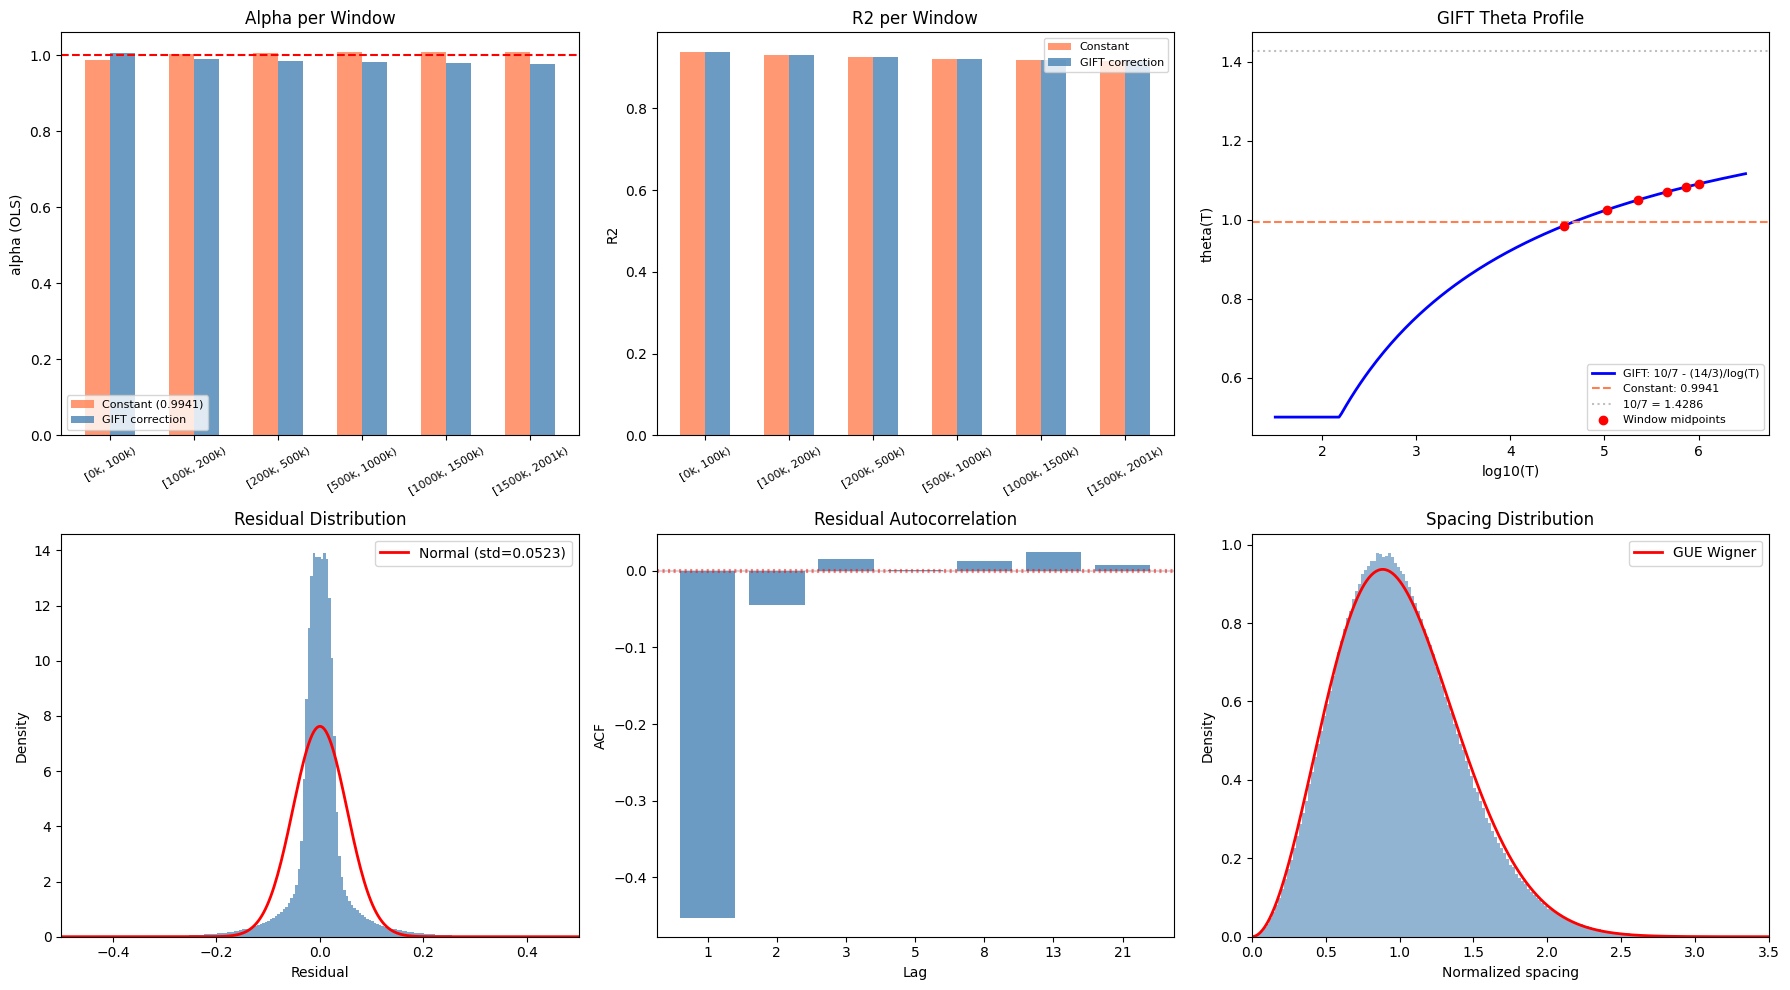

In [9]:
import matplotlib.pyplot as plt

print("=" * 60)
print("RESIDUAL DIAGNOSTICS")
print("=" * 60)

# ACF
res_c = residuals - np.mean(residuals)
var_res = np.var(res_c)
lags = [1, 2, 3, 5, 8, 13, 21]
acf_r = [float(np.mean(res_c[l:]*res_c[:-l])/var_res) for l in lags]
wn_bound = 1.96 / np.sqrt(N_ZEROS)

print(f"\n  Residual ACF (white-noise bound: +/-{wn_bound:.5f}):")
for i, l in enumerate(lags):
    sig = "***" if abs(acf_r[i]) > wn_bound else ""
    print(f"    lag {l:>3}: {acf_r[i]:+.6f} {sig}")

print(f"\n  GUE prediction for lag-1: ~-0.47")
print(f"  Our lag-1 residual ACF:    {acf_r[0]:+.4f}")

# Variance decomposition
vd = float(np.var(delta))
vp = float(np.var(delta_pred))
vr = float(np.var(residuals))
print(f"\n  Var(delta):     {vd:.6f}")
print(f"  Var(pred):      {vp:.6f}  ({100*vp/vd:.1f}%)")
print(f"  Var(residual):  {vr:.6f}  ({100*vr/vd:.1f}%)")

# ── Figures ──
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# (0,0) Window alphas: GIFT vs constant
ax = axes[0, 0]
const_alphas = [0.9869, 1.0029, 1.0059, 1.0082, 1.0093, 1.0097]  # from original
gift_alphas = [w['alpha'] for w in window_results]
x_w = np.arange(len(gift_alphas))
ax.bar(x_w - 0.15, const_alphas, 0.3, label='Constant (0.9941)', color='coral', alpha=0.8)
ax.bar(x_w + 0.15, gift_alphas, 0.3, label='GIFT correction', color='steelblue', alpha=0.8)
ax.axhline(1.0, color='red', ls='--', lw=1.5)
ax.set_xticks(x_w)
ax.set_xticklabels([w['window'] for w in window_results], rotation=30, fontsize=8)
ax.set_ylabel('alpha (OLS)')
ax.set_title('Alpha per Window')
ax.legend(fontsize=8)

# (0,1) Window R2: GIFT vs constant
ax = axes[0, 1]
const_R2 = [0.9394, 0.9298, 0.9249, 0.9208, 0.9183, 0.9165]
gift_R2 = [w['R2'] for w in window_results]
ax.bar(x_w - 0.15, const_R2, 0.3, label='Constant', color='coral', alpha=0.8)
ax.bar(x_w + 0.15, gift_R2, 0.3, label='GIFT correction', color='steelblue', alpha=0.8)
ax.set_xticks(x_w)
ax.set_xticklabels([w['window'] for w in window_results], rotation=30, fontsize=8)
ax.set_ylabel('R2')
ax.set_title('R2 per Window')
ax.legend(fontsize=8)

# (0,2) Theta profile
ax = axes[0, 2]
T_plot = np.logspace(1.5, 6.5, 200)
ax.plot(np.log10(T_plot), theta_gift(T_plot), 'b-', lw=2, label='GIFT: 10/7 - (14/3)/log(T)')
ax.axhline(0.9941, color='coral', ls='--', label='Constant: 0.9941')
ax.axhline(THETA_INF, color='gray', ls=':', alpha=0.5, label=f'10/7 = {THETA_INF:.4f}')
T_mids = [(w['T_lo']+w['T_hi'])/2 for w in window_results]
ax.plot(np.log10(T_mids), [w['theta_mid'] for w in window_results],
        'ro', ms=6, label='Window midpoints')
ax.set_xlabel('log10(T)')
ax.set_ylabel('theta(T)')
ax.set_title('GIFT Theta Profile')
ax.legend(fontsize=8)

# (1,0) Residual histogram
ax = axes[1, 0]
ax.hist(residuals, bins=200, density=True, alpha=0.7, color='steelblue')
from scipy.stats import norm
xn = np.linspace(-0.5, 0.5, 300)
ax.plot(xn, norm.pdf(xn, np.mean(residuals), np.std(residuals)),
        'r-', lw=2, label=f'Normal (std={np.std(residuals):.4f})')
ax.set_xlabel('Residual')
ax.set_ylabel('Density')
ax.set_title('Residual Distribution')
ax.legend()
ax.set_xlim(-0.5, 0.5)

# (1,1) ACF bars
ax = axes[1, 1]
ax.bar(range(len(lags)), acf_r, color='steelblue', alpha=0.8)
ax.axhline(0, color='gray', alpha=0.3)
ax.axhline(wn_bound, color='red', ls=':', alpha=0.5)
ax.axhline(-wn_bound, color='red', ls=':', alpha=0.5)
ax.set_xticks(range(len(lags)))
ax.set_xticklabels([str(l) for l in lags])
ax.set_xlabel('Lag')
ax.set_ylabel('ACF')
ax.set_title('Residual Autocorrelation')

# (1,2) Spacing distribution
ax = axes[1, 2]
spacings = np.diff(gamma_n) / np.mean(np.diff(gamma_n))
ax.hist(spacings, bins=200, range=(0, 4), density=True, alpha=0.6, color='steelblue')
s_grid = np.linspace(0.01, 4, 500)
P_gue = (32/np.pi**2) * s_grid**2 * np.exp(-4*s_grid**2/np.pi)
ax.plot(s_grid, P_gue, 'r-', lw=2, label='GUE Wigner')
ax.set_xlabel('Normalized spacing')
ax.set_ylabel('Density')
ax.set_title('Spacing Distribution')
ax.legend()
ax.set_xlim(0, 3.5)

plt.tight_layout()
plt.savefig('gift_correction_2M_results.png', dpi=150, bbox_inches='tight')
if DRIVE_DIR:
    shutil.copy2('gift_correction_2M_results.png',
                 os.path.join(DRIVE_DIR, 'gift_correction_2M_results.png'))
print("Saved gift_correction_2M_results.png")
plt.show()

In [10]:
print("=" * 60)
print("SAVING RESULTS")
print("=" * 60)

results = {
    'metadata': {
        'date': time.strftime('%Y-%m-%d'),
        'model': 'GIFT correction: theta(T) = 10/7 - (14/3)/log(T)',
        'theta_inf': float(THETA_INF),
        'theta_coeff': float(THETA_COEFF),
        'theta_inf_origin': '(dim(K7) + N_gen) / dim(K7) = 10/7',
        'coeff_origin': '-dim(G2) / N_gen = -14/3',
        'N_zeros': int(N_ZEROS),
        'T_max': float(gamma_n[-1]),
        'k_max': K_MAX,
        'P_max': int(primes[-1]),
        'n_primes': int(len(primes)),
        'mollifier': 'cosine',
        'source': 'Odlyzko zeros6',
    },
    'global': {
        'alpha_OLS': float(alpha_OLS),
        'R2_alpha1': float(R2_global),
        'R2_alphaOLS': float(R2_scaled),
        'E_rms': float(np.sqrt(np.mean(residuals**2))),
        'E_max': float(np.max(np.abs(residuals))),
        'localization': float(loc_rate),
    },
    'comparison_to_constant': {
        'constant_alpha': 1.006358,
        'constant_R2': 0.9219,
        'constant_score': '1/3',
    },
    'validation': {
        'T5': {
            'pass': bool(T5_pass),
            'T5a_margin': float(margin_a),
            'T5a_pval': float(p_val_a),
            'T5b_margin': float(margin_b),
            'T5b_pval': float(p_val_b),
            'n_trials': N_TRIALS,
        },
        'T7_bootstrap': {
            'pass': bool(T7_pass),
            'alpha_hat': float(alpha_OLS),
            'CI_lo': float(ci_lo),
            'CI_hi': float(ci_hi),
            'B': B,
        },
        'T8_drift': {
            'pass': bool(T8_pass),
            'slope': float(slope),
            'p_value': float(p_val_drift),
        },
        'score': f'{n_pass}/3',
    },
    'windows': window_results,
    'residual_acf': {f'lag_{l}': float(acf_r[i]) for i, l in enumerate(lags)},
}

# Save JSON
out_file = 'gift_correction_2M_full_results.json'
with open(out_file, 'w') as f:
    json.dump(results, f, indent=2)
print(f"  {out_file}")

# Save .npy
np.save('dp_gift_correction_2M.npy', delta_pred)
print(f"  dp_gift_correction_2M.npy ({delta_pred.nbytes/1e6:.1f} MB)")

# Drive backup
if DRIVE_DIR:
    for f in [out_file, 'dp_gift_correction_2M.npy',
              'gift_correction_2M_results.png']:
        if os.path.exists(f):
            shutil.copy2(f, os.path.join(DRIVE_DIR, f))
            print(f"  -> Drive: {f}")

# Browser download
try:
    from google.colab import files
    print("\nTriggering browser downloads:")
    files.download(out_file)
    files.download('gift_correction_2M_results.png')
    print("  Downloads triggered (JSON + PNG)")
    # .npy too large for browser, Drive only
except ImportError:
    print("\nNot in Colab — files saved locally")

print(f"\n{'=' * 60}")
print(f"DONE. GIFT Correction Model Results:")
print(f"  Score:    {n_pass}/3  (constant model: 1/3)")
print(f"  alpha:    {alpha_OLS:.6f}  (constant: 1.006358)")
print(f"  R2:       {R2_global:.6f}  (constant: 0.9219)")
print(f"  Loc:      {loc_rate*100:.2f}%")
print(f"{'=' * 60}")

SAVING RESULTS
  gift_correction_2M_full_results.json
  dp_gift_correction_2M.npy (16.0 MB)

Triggering browser downloads:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  Downloads triggered (JSON + PNG)

DONE. GIFT Correction Model Results:
  Score:    0/3  (constant model: 1/3)
  alpha:    0.983371  (constant: 1.006358)
  R2:       0.922576  (constant: 0.9219)
  Loc:      97.35%
